In [1]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import string
import re
import helpers
import figures

Lets look at the data from Kaggle!

In [2]:
data = pd.read_csv("spam.csv",encoding='latin-1')
data.dtypes

v1            object
v2            object
Unnamed: 2    object
Unnamed: 3    object
Unnamed: 4    object
dtype: object

All the columns are *object* data types, we have only text info in each of the columns.

To check if there is any null values in the columns

In [3]:
data.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [4]:
data.count()

v1            5572
v2            5572
Unnamed: 2      50
Unnamed: 3      12
Unnamed: 4       6
dtype: int64

*Unnamed: 2*, *Unnamed: 3*, and *Unnamed: 4* have large amount of null values (also the proportion of of null to non-null values are large)
The desciption of the dataset does says that v1 is the classification and v2 is the message, so the other columns having a lot of null values makes sense. I would why it was included?

Since columns v1 and v2 are the columns that will work the best, We can keep v1 and v2 because and rename them to help clarity

In [5]:
data = data.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"],axis=1)

In [6]:
data = data.rename(columns={"v1":"class","v2":"msg"})
data

,class,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Creating a word map of both Spam and Ham messages will help us visualise a difference between the two groups

In [7]:
spam = data[data['class'] == 'spam']
ham = data[data['class'] == 'ham']

spam_words = helpers.get_words(spam.msg)
ham_words = helpers.get_words(ham.msg)

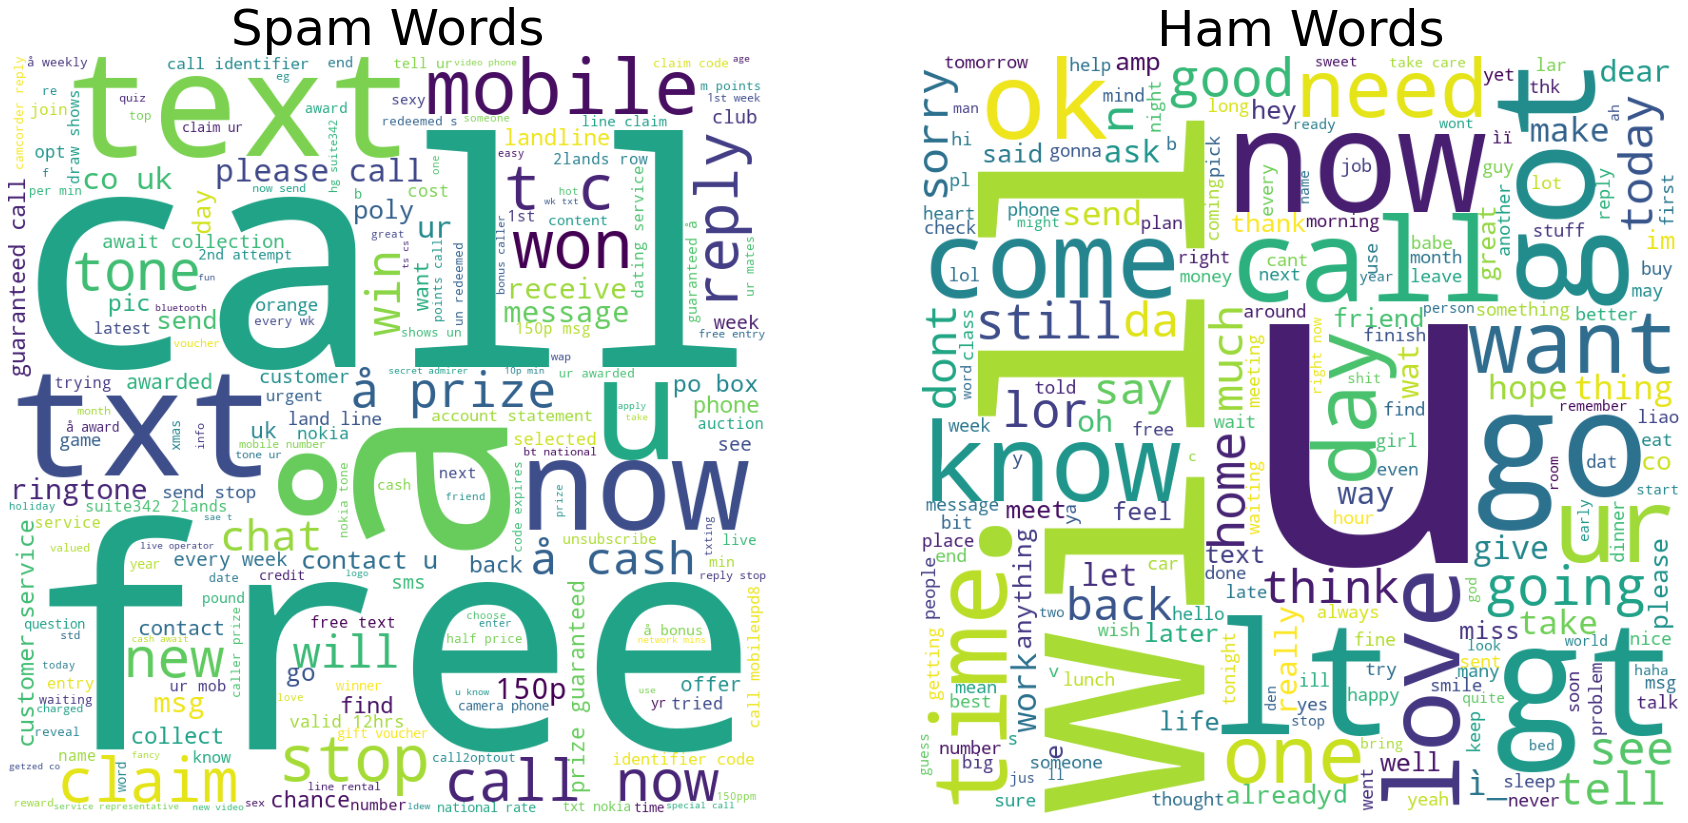

In [8]:
figures.plot_wordclouds(spam_words,ham_words)

Spam sms messages have words like "txt, call, free, mobile,..." and not spam words (called ham?) are "will, u, now, go,..."
There are words that each of the sets have in common ("u, now, call,..") but hopefully there is a big difference bettween spam and ham messages that the model can tell the difference most of the time

Lets start cleaning the data. The goal is to create the smallest set of unique words that will hopefully indenty if the sms message is spam or not. Punctuation and whitespaces will be remove because whitespaces will help us indicate the class and punctuation will be removed since "Hello!!!" is just "Hello" in meaning (although you could argue that punctuation could help classify the data we want the smallest set possible). Stopping words, which are commonly used words in the english language (They should appear frequently in both classes) will be removed along with any numbers.

We will also try to get words to a root form by using stemming techniques such as PorterStemmer and WordNetLemmatizer. 

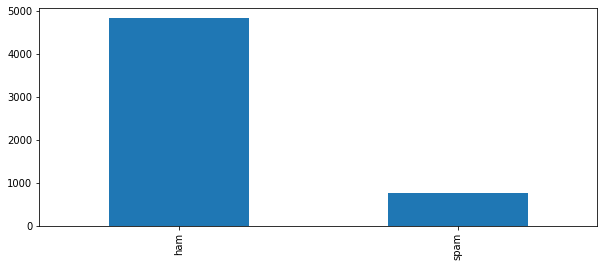

In [9]:
plt.figure(figsize=(10,4))
data['class'].value_counts().plot(kind='bar');

In [10]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/piercson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
def clean_text(col, technique):
    stopwords = STOPWORDS
    output = []
    if technique == 'PorterStemmer':
        tech = PorterStemmer()
        get_root = tech.stem
    else:
        tech = WordNetLemmatizer()
        get_root = tech.lemmatize
    
    tokens = col.split()
    for token in tokens:
        cleaned_token = token.lower()
        if token in stopwords:
            continue
        cleaned_token = re.sub(r'[0-9]+', '', cleaned_token)
        cleaned_token = re.sub(r'[^\w\s]', '', cleaned_token)
        cleaned_token = re.sub(r'[_]', '', cleaned_token)
        cleaned_token = get_root(cleaned_token)
        output.append(cleaned_token)
    output = list(filter(lambda x: x!='',output)) 
    return " ".join(word for word in output)

data['cleaned_stemm'] = data.msg.apply(clean_text,technique='PorterStemmer')
data['cleaned_lemm'] = data.msg.apply(clean_text,technique='WordNetLemmatizer')
data

,class,msg,cleaned_stemm,cleaned_lemm
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i think goe usf live around though,nah i think go usf life around though
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,thi nd time tri contact u u won å pound prize ...,this nd time tried contact u u won å pound pri...
5568,ham,Will Ì_ b going to esplanade fr home?,will ì b go esplanad fr home,will ì b going esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",piti mood that soani suggest,pity mood that soany suggestion
5570,ham,The guy did some bitching but I acted like i'd...,the guy bitch i act interest buy someth next w...,the guy bitching i acted interested buying som...


In [12]:
X = data.cleaned_stemm
y = data['class']


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

import seaborn as sns

nb_pipe = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB()),
                  ])

X_train, X_valid, y_train, y_valid = train_test_split(X, y,train_size=0.7, test_size=0.3,random_state=0)
model = nb_pipe.fit(X_train, y_train)
y_pred = model.predict(X_valid)
labels = ['spam',"ham"]
print('accuracy %f',accuracy_score(y_pred, y_valid))
print(classification_report(y_valid, y_pred,target_names=labels))
cf = confusion_matrix(y_valid,y_pred,labels=labels)
labels = ['Spam',"Ham"]
pd.crosstab(y_valid, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)
# sns.heatmap(cf,cbar=False,xticklabels=labels,yticklabels=labels,annot=True,fmt="d",cmap='Blues')

accuracy %f 0.9521531100478469
              precision    recall  f1-score   support

        spam       0.95      1.00      0.97      1434
         ham       1.00      0.66      0.80       238

    accuracy                           0.95      1672
   macro avg       0.97      0.83      0.89      1672
weighted avg       0.95      0.95      0.95      1672



Predicted,ham,spam,All
Actual,,,
ham,1434,0,1434
spam,80,158,238
All,1514,158,1672


In [71]:
print("Row 0", 1434/1434)
print("Row 1", 158/238)
print("col 0", 1434/1514)
print("col 1", 158/158)

Row 0 1.0
Row 1 0.6638655462184874
col 0 0.9471598414795245
col 1 1.0


accuracy 0.9826555023923444
              precision    recall  f1-score   support

        Spam       0.99      0.99      0.99      1434
         Ham       0.96      0.91      0.94       238

    accuracy                           0.98      1672
   macro avg       0.97      0.95      0.96      1672
weighted avg       0.98      0.98      0.98      1672

0.9826555023923444


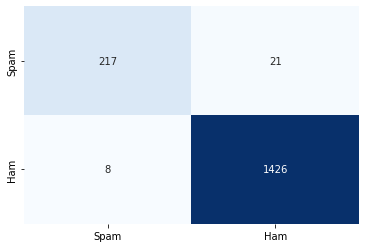

In [32]:
from sklearn.linear_model import SGDClassifier 
nb_pipe = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('linear_svm', SGDClassifier(loss='hinge',penalty='l2', alpha=1e-5, random_state=0, max_iter=1000)),
                  ])

X_train, X_valid, y_train, y_valid = train_test_split(X, y,train_size=0.7, test_size=0.3,random_state=0)
model = nb_pipe.fit(X_train, y_train)
y_pred = model.predict(X_valid)
labels = ['Spam',"Ham"]
print('accuracy %s' % accuracy_score(y_pred, y_valid))
print(classification_report(y_valid, y_pred,target_names=labels))
cf = confusion_matrix(y_valid,y_pred,labels=["spam","ham"])
labels = ['Spam',"Ham"]
sns.heatmap(cf,cbar=False,xticklabels=labels,yticklabels=labels,annot=True,fmt="d",cmap='Blues')
print(model.score(X_valid,y_valid))